In [174]:
library(dplyr)
library(ggplot2)
library(zeallot)
library(tidyr)
library(reshape2)
library(cowplot)

In [175]:
analysis <- function(X, Y, display_plot=TRUE){
    spearman <- cor(X, Y, use="pairwise.complete.obs", method="spearman")
    pearson <- cor(X, Y, use="pairwise.complete.obs", method="pearson")
    print(c("Pearson", pearson))
    print(c("Spearman", spearman))
    if (display_plot) {
        ggplot() + geom_point(aes(x=X, y=Y))
    }
}

regression <- function(X, Y, display_plot=TRUE){
    r <- cor(X, Y, use="pairwise.complete.obs")
    Sx <- sd(X)
    Sy <- sd(Y)
    a <- r * Sy / Sx
    b <- mean(Y) - a * mean(X)

    if(display_plot){
        xs <- seq(min(X), max(X), 0.01)
        plt <- ggplot() +
            geom_point(aes(x=X, y=Y), alpha=0.5) +
            geom_line(aes(x = xs, y = a * xs + b), linewidth=1, col="red")
        show(plt)
    }

    return(c(a, b))
}

In [176]:
data <- read.csv("data/data.csv")
data2015 <- data %>% filter(year == 2015)

In [74]:
data_filtered <- data2015 %>% filter(!is.na(schooling) & !is.na(life_expectancy))
X <- data_filtered$schooling
Y <- data_filtered$life_expectancy

[1] "Pearson"           "0.818159436788872"
[1] "Spearman"          "0.844347924774132"


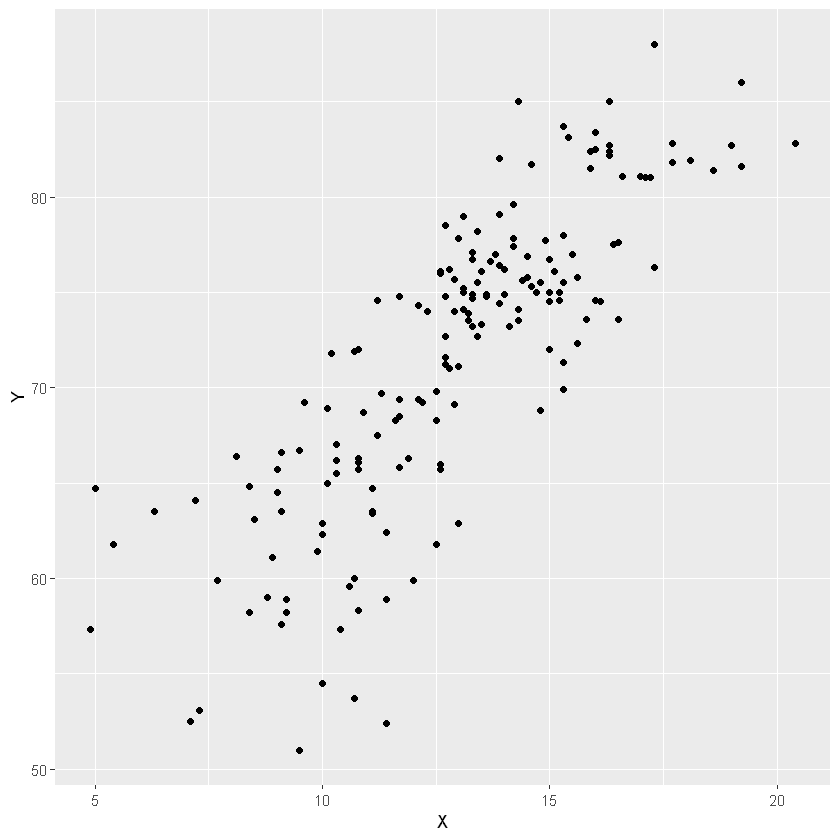

In [75]:
analysis(X, Y)

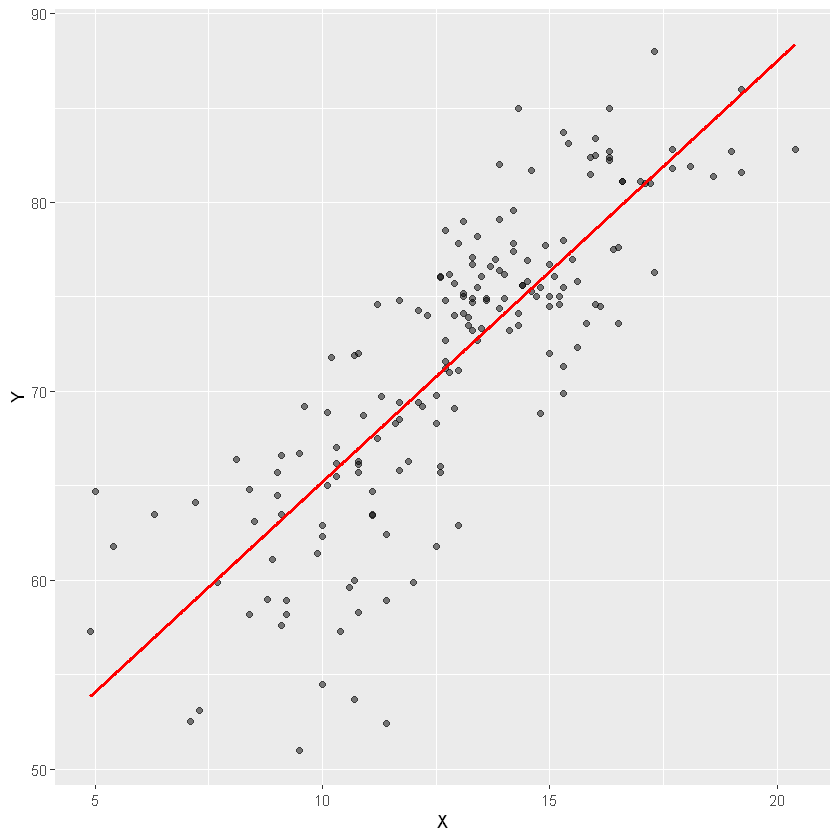

In [76]:
c(a, b) %<-% regression(X, Y)

# Wykresy

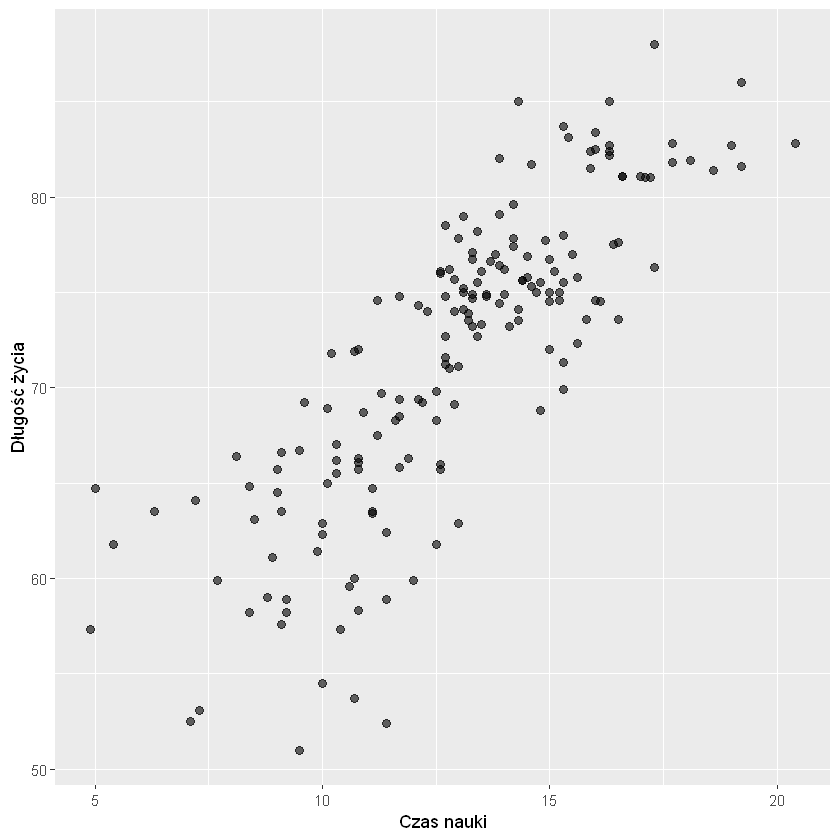

In [171]:
ggplot() + 
  geom_point(aes(X, Y), alpha=0.6, size=2.2) + 
  xlab("Czas nauki") +
  ylab("Długość życia")

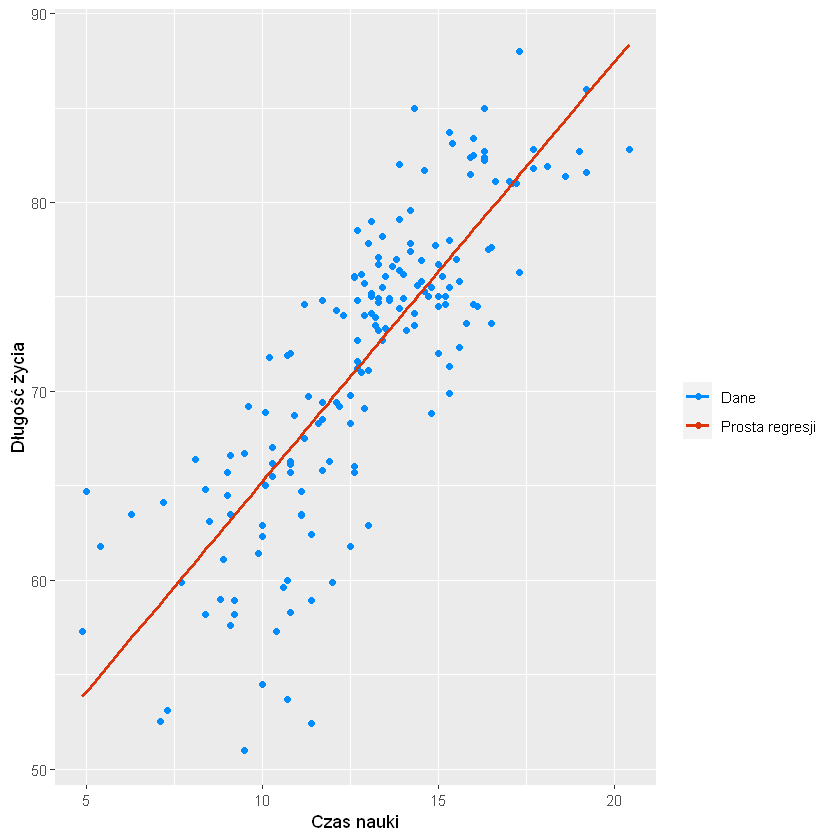

In [187]:
ggplot() + 
  geom_point(aes(X, Y, col='a')) + 
  geom_line(aes(X, a*X + b, col='b'), linewidth=1) + 
  scale_color_manual(labels=c("Dane", "Prosta regresji"), values=c('#008cff', "#da350b")) +
  labs(col="") +
  xlab("Czas nauki") +
  ylab("Długość życia")

In [173]:
E <- Y - a*X - b
df <- data.frame(X=X, Y=Y, E=E)
df <- df %>% arrange(X)

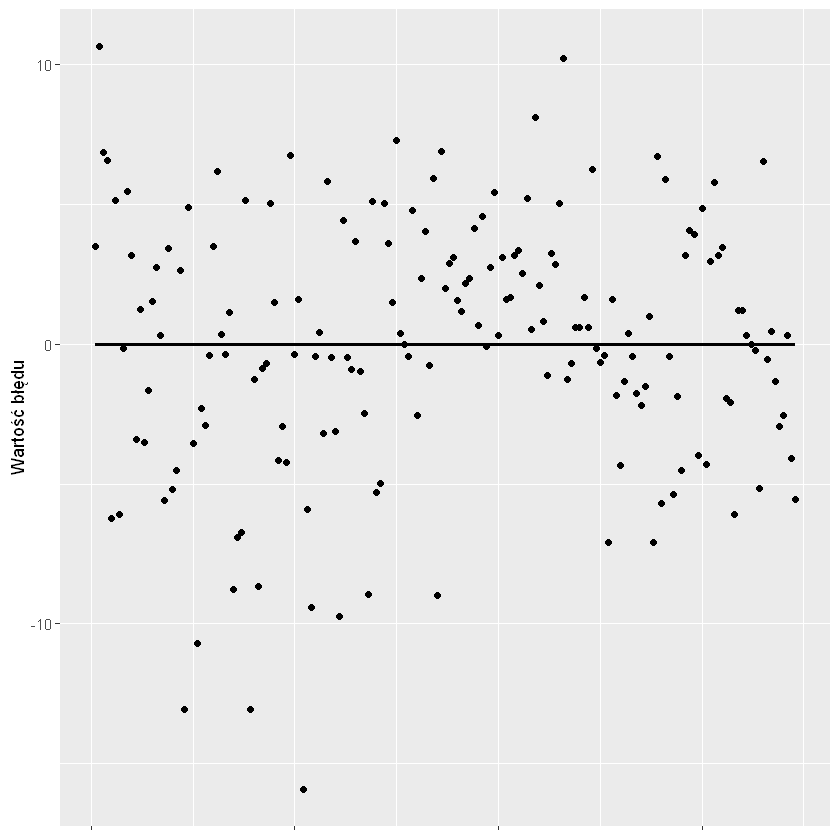

In [172]:
ggplot() + 
  geom_point(aes(1:length(E), df$E)) + 
  geom_line(aes(1:length(E), 0), linewidth=1) +
  labs(col="") +
  theme(axis.title.x=element_blank(), axis.text.x=element_blank()) +
  ylab("Wartość błędu")

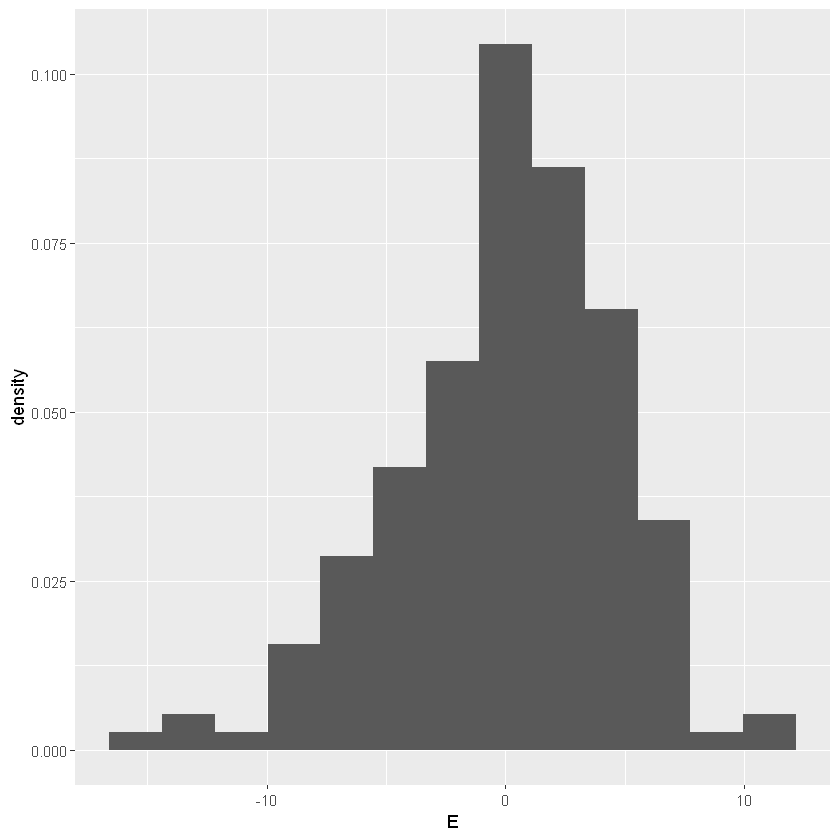

In [59]:
ggplot() + geom_histogram(aes(x=E, y=..density..), bins=13)

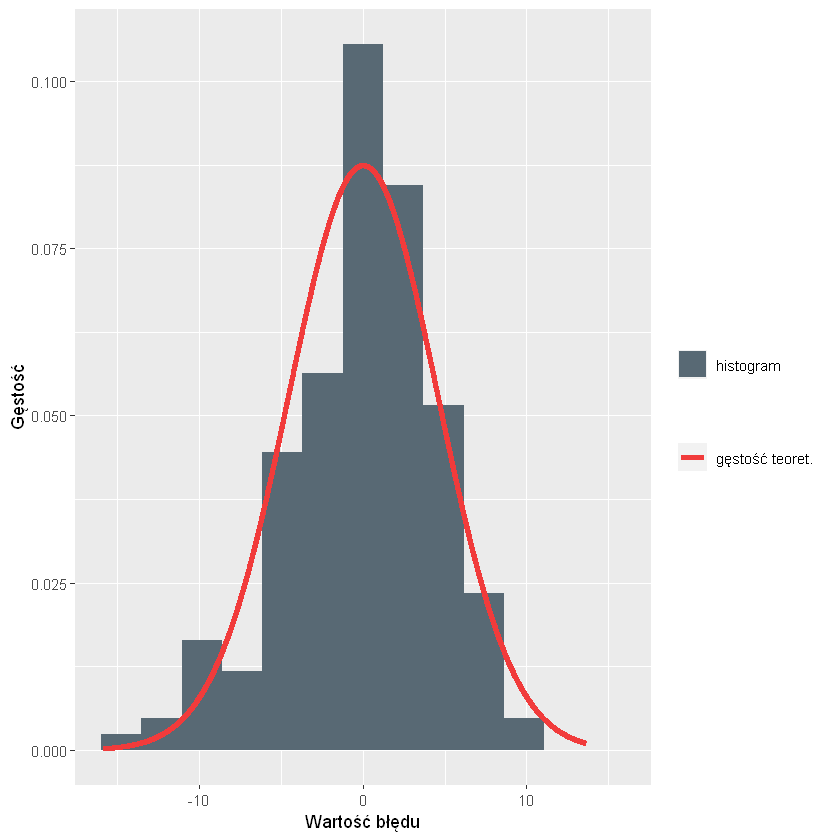

In [181]:
xs <- seq(min(E), max(E) + 3, 0.01)
plt1 <- ggplot() + 
  geom_histogram(aes(x=E, y=..density.., fill='a'), bins=13) + 
  geom_line(aes(xs, dnorm(xs, 0, sd(E)), col='b'), linewidth=1.5) + 
  scale_color_manual(labels=c("gęstość teoret."), values=c('#f13b3b')) +
  scale_fill_manual(labels=c("histogram"), values=c('#586974')) +
  labs(col="", fill="") +
  xlab("Wartość błędu") +
  ylab("Gęstość")
plt1

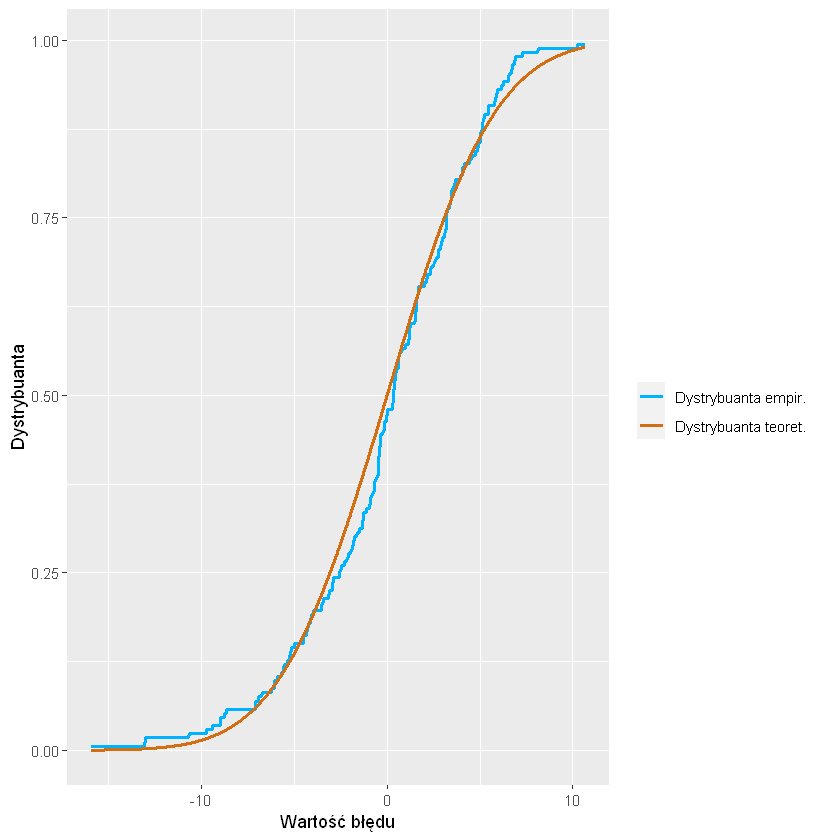

In [180]:
F <- ecdf(E)
xs <- seq(min(E), max(E), 0.01)
plt2 <- ggplot() + 
  geom_line(aes(x=xs, y=F(xs), col='a'), linewidth=1) + 
  geom_line(aes(x=xs, y=pnorm(xs, 0, sd(E)), col='b'), linewidth=1) +
  scale_color_manual(labels=c("Dystrybuanta empir.", "Dystrybuanta teoret."), values=c('#00b3ff', "#d36f12")) +
  labs(col="") +
  xlab("Wartość błędu") +
  ylab("Dystrybuanta")
plt2

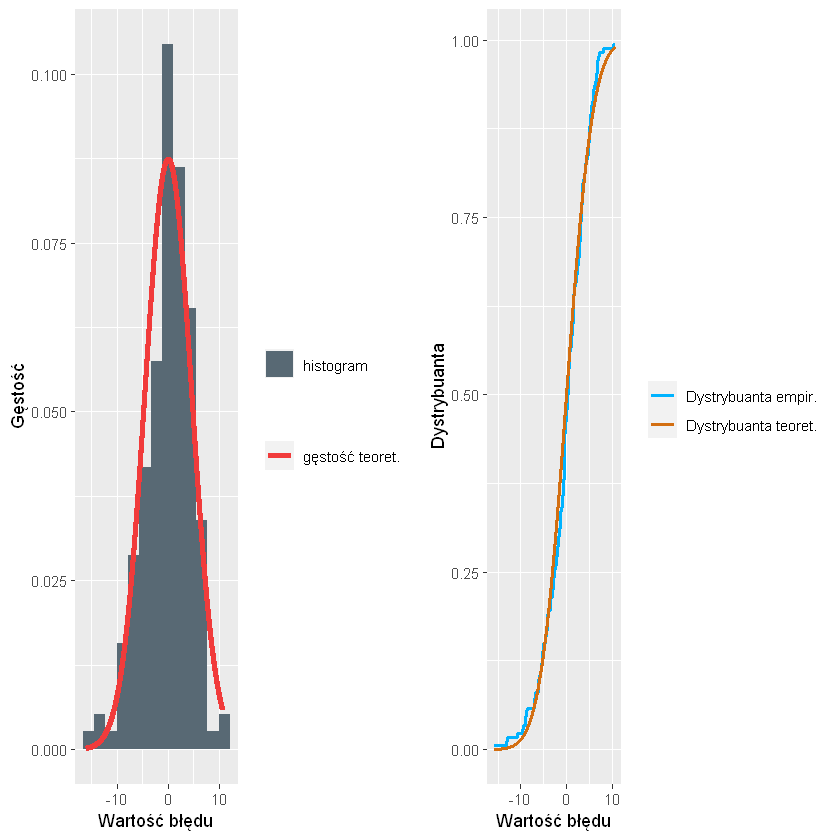

In [179]:
plot_grid(plt1, plt2)

In [22]:
ks.test(E, 'pnorm', 0, sd(E))

Warning message in ks.test.default(E, "pnorm", 0, sd(E)):
"wartości powtórzone nie powinny być obecne w teście Kolmogorowa-Smirnowa"



	Asymptotic one-sample Kolmogorov-Smirnov test

data:  E
D = 0.077247, p-value = 0.2532
alternative hypothesis: two-sided


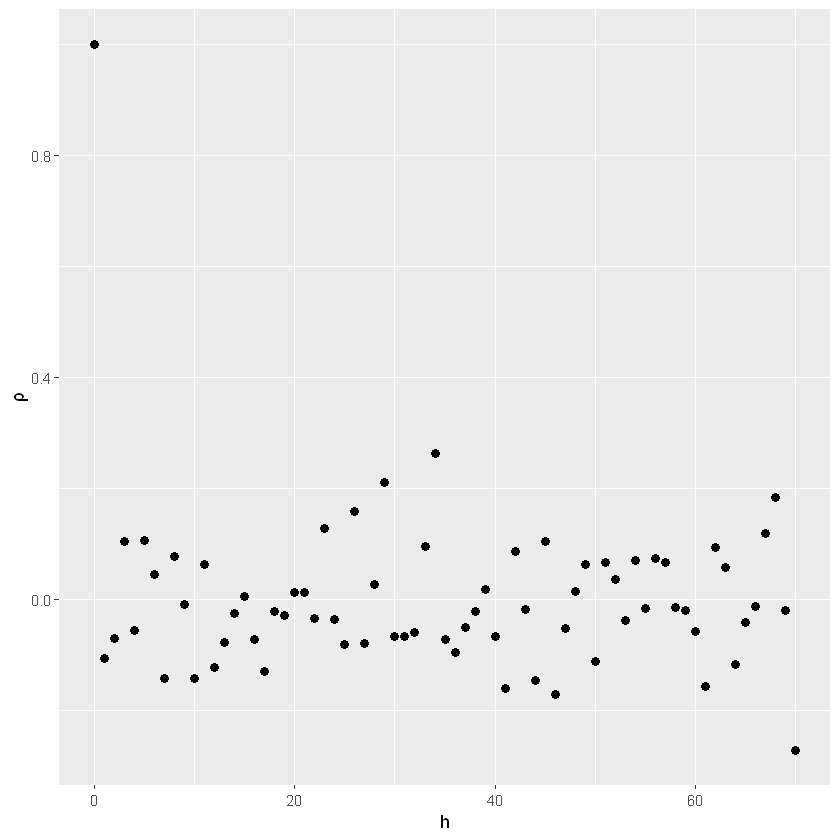

In [136]:
n <- length(E)
hs <- 0:70
Xt <- rnorm(n, 0, sd(E))

g_ <- function(X, h) {
    return ( mean( (X[(1+h):n] - mean(X)) * (X[1:(n-h)] - mean(X)) ) )
}

g_s <- c()
g_s2 <- c()
for (h in hs) {
    g_s <- append(g_s, g_(E, h))
    g_s2 <- append(g_s2, g_(Xt, h))
}

r_s = g_s / g_(E, 0)
r_s2 = g_s2 / g_(Xt, 0)

ggplot() + 
  geom_point(aes(hs, r_s), size=2.2) +
  #scale_color_manual(labels=c("", ""), values=c('#00b3ff', "#d36f12")) +
  labs(col="") +
  xlab("h") +
  ylab("ρ")

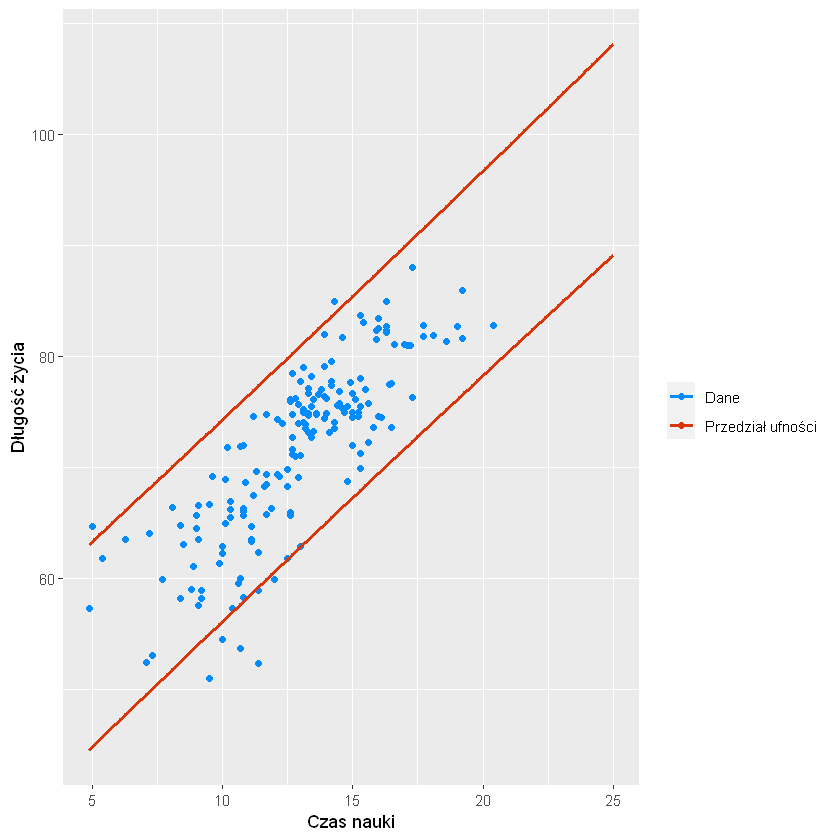

In [120]:
n <- length(X)
α <- 0.05

t <- qt(1 - α/2, n - 2)

S <- sqrt(sum((Y - a * X - b)^2) / (n - 2))

X0 <- seq(min(X), 25, 0.1)
Y_ <- a * X0 + b

Yd_n <- Y_ - t * S * sqrt(1 + 1/n + (X0 - mean(X))^2 / sum((X - mean(X))^2))
Yg_n <- Y_ + t * S * sqrt(1 + 1/n + (X0 - mean(X))^2 / sum((X - mean(X))^2))

ggplot() + 
  geom_point(aes(X, Y, col='a')) + 
  geom_line(aes(X0, Yd_n, col='b'), linewidth=1) + 
  geom_line(aes(X0, Yg_n, col='b'), linewidth=1) +
  scale_color_manual(labels=c("Dane", "Przedział ufności"), values=c('#008cff', "#da350b")) +
  labs(col="") +
  xlab("Czas nauki") +
  ylab("Długość życia")

# GDP

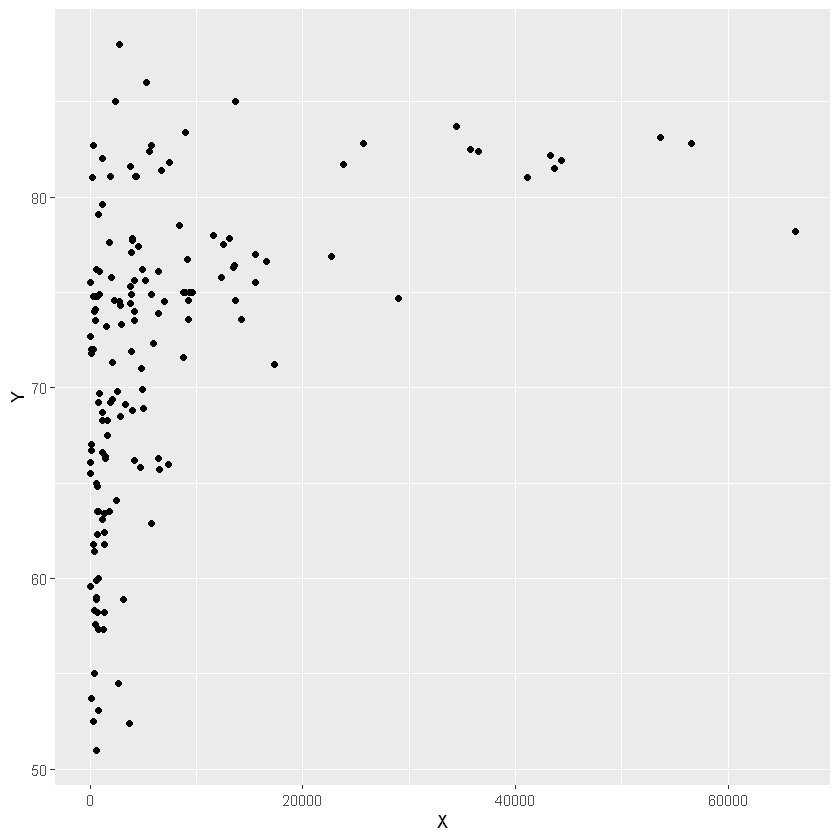

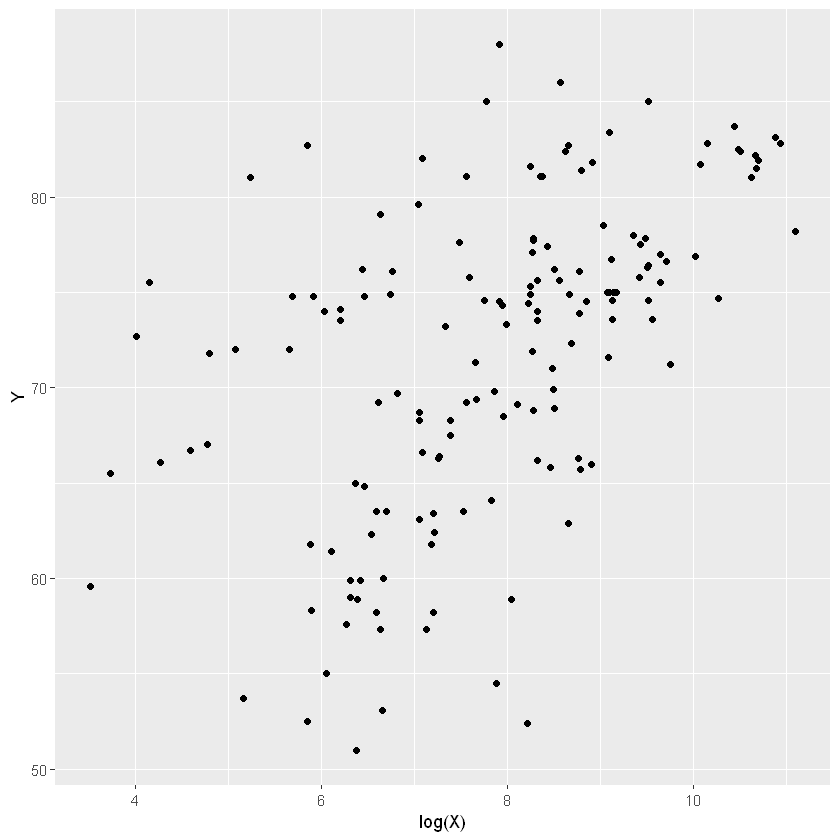

In [6]:
data_filtered <- data2015[!is.na(data2015$GDP) & !is.na(data2015$life_expectancy),]
X <- data_filtered$GDP
Y <- data_filtered$life_expectancy

ggplot() + geom_point(aes(X, Y))
ggplot() + geom_point(aes(log(X), Y))

In [7]:
cor(log(X), Y)

[1] 0.5208085

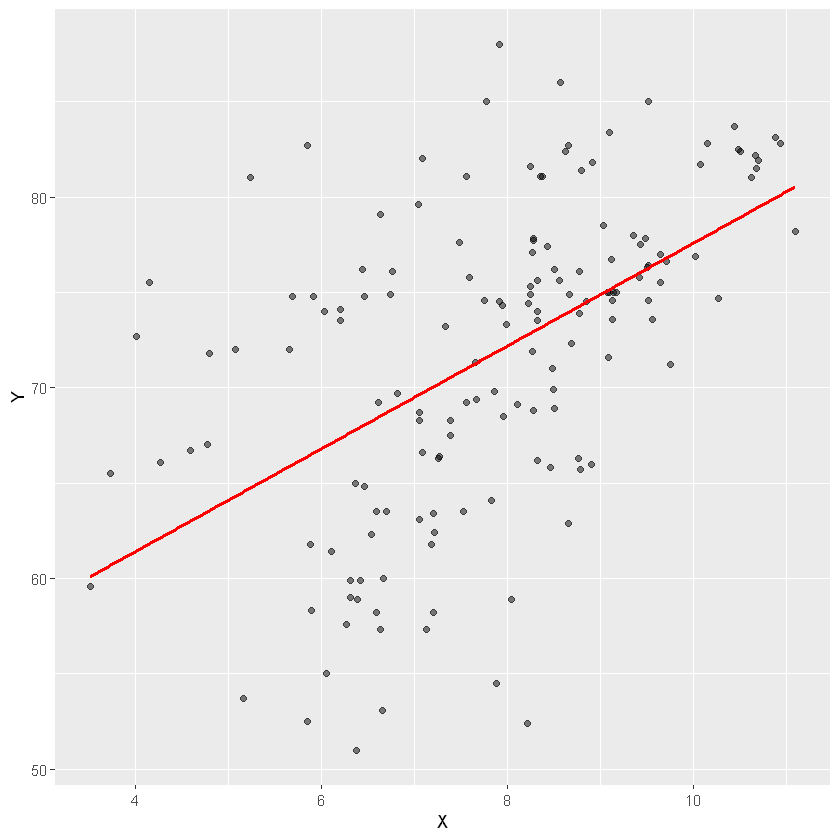

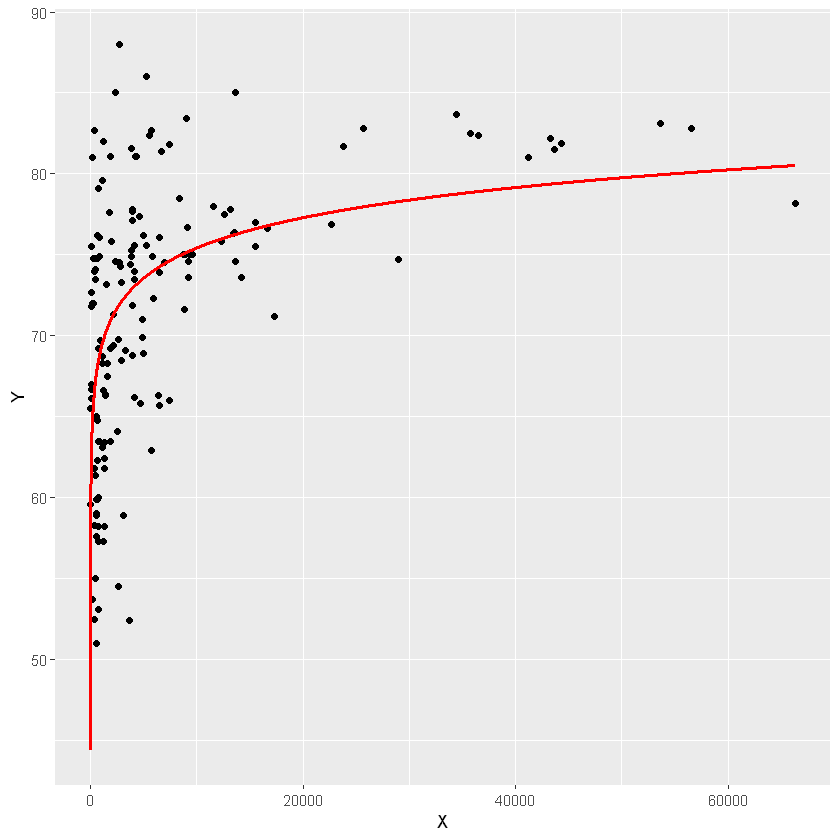

In [9]:
c(a, b) %<-% regression(log(X), Y)
xs <- seq(0.1, max(X), 10)
ggplot() + geom_point(aes(X, Y)) + geom_line(aes(xs, a*log(xs) + b), col='red', linewidth=1)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


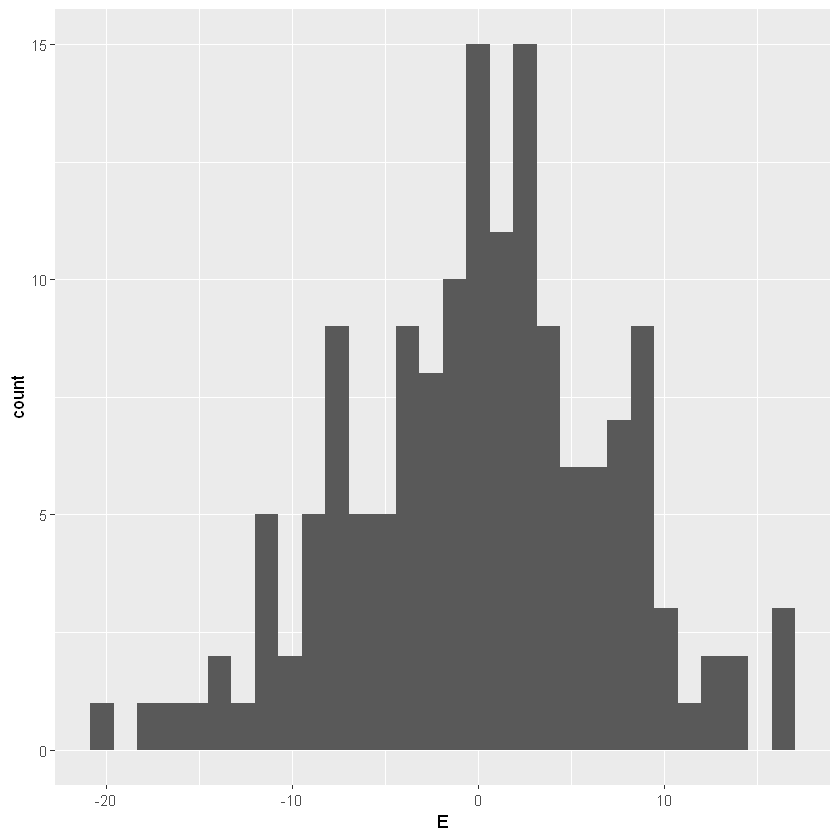

In [12]:
E <- Y - a*log(X) - b
ggplot() + geom_histogram(aes(E))

In [46]:
ks.test(E, 'pnorm', 0, sd(E))


	Asymptotic one-sample Kolmogorov-Smirnov test

data:  E
D = 0.045116, p-value = 0.9126
alternative hypothesis: two-sided


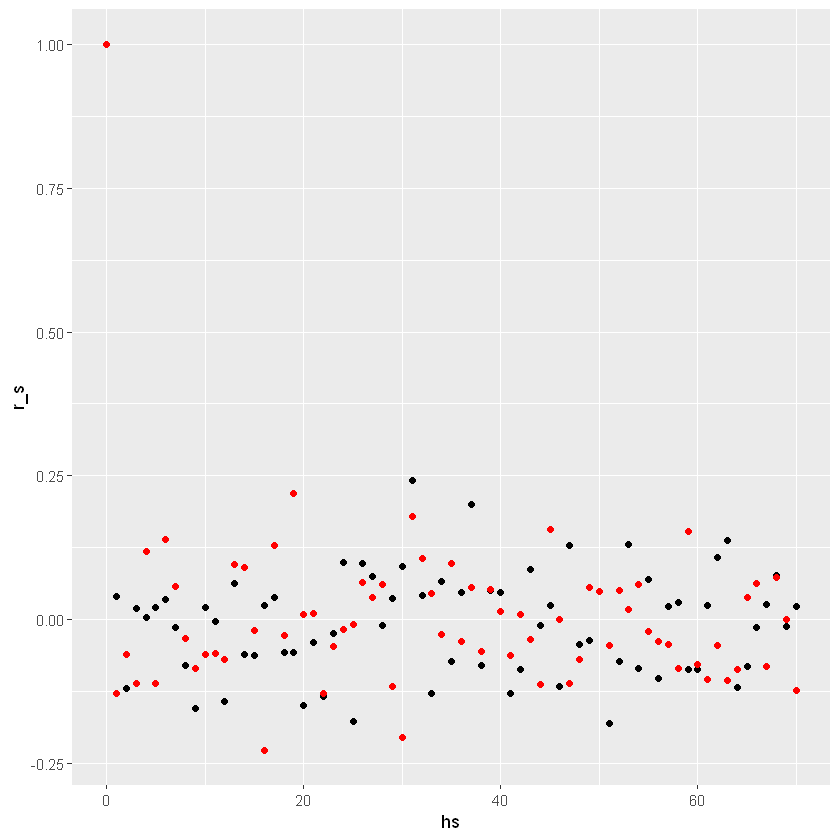

In [82]:
n <- length(E)
hs <- 0:70
Xt <- rnorm(n, 0, sd(E))

g_ <- function(X, h) {
    return ( mean( (X[(1+h):n] - mean(X)) * (X[1:(n-h)] - mean(X)) ) )
}

g_s <- c()
g_s2 <- c()
for (h in hs) {
    g_s <- append(g_s, g_(E, h))
    g_s2 <- append(g_s2, g_(Xt, h))
}

r_s = g_s / g_(E, 0)
r_s2 = g_s2 / g_(Xt, 0)

ggplot() + geom_point(aes(hs, r_s)) + geom_point(aes(hs, r_s2), col='red')